## Домашнее задание 2

1) Функция кросс-валидации

2) Модели

Важно! Регуляризация

*   Логистическая регрессия
*   WoE
*   Дополнительно: усреднение предсказаний сделанных моделей и его засбмитить

2) Для каждой модели сделать кросс-валидацию и засабмитить предсказание на тестовой выборке на кагл

4) Построить график зависимости Leader board score от score на кросс-валидации для всех 5 моделей (ROC AUC)

5) Написать отчет с выводами

*Код для построения графика ROC взят отсюда: https://medium.com/nuances-of-programming/%D0%BF%D0%BE%D1%88%D0%B0%D0%B3%D0%BE%D0%B2%D0%BE%D0%B5-%D0%BF%D0%BE%D1%81%D1%82%D1%80%D0%BE%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BB%D0%BE%D0%B3%D0%B8%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9-%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%81%D0%B8%D0%B8-%D0%B2-python-a7c650ae77c2*

## 0) Импорты и данные

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
# раскомментировать для google.colab

# from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# подгружаем данные

# раскомментировать для google.colab
# sample_submission = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/project2/data/sample_submission.csv")
# train_df = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/project2/data/application_train.csv")
# test_df = pd.read_csv("/content/drive/My Drive/1_MIPTxSkolkovo/ML/project2/data/application_test.csv")

# закомментировать для google.colab
sample_submission = pd.read_csv("../data/sample_submission.csv")
train_df = pd.read_csv("../data/application_train.csv")
test_df = pd.read_csv("../data/application_test.csv")

## 1) Подготовка данных

### 1.1) Выбранные признаки

Выберем несколько признаков, которые кажутся наиболее релевантными, и сосредоточимся на них:

*   Непрерывные числовые, непосредственно связанные с деньгами: доход, ежемесячный платеж **['AMT_INCOME_TOTAL', 'AMT_ANNUITY']**
*   Непрерывные числовые, связанные со временем: возраст и срок трудоустройства на последней работе **['DAYS_BIRTH', 'DAYS_EMPLOYED']**
*   Бинарные: наличие в собственности машины и недвижимости **['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']**
*   Категориальные: семейное положение **['NAME_FAMILY_STATUS']**
*   Непрерывные числовые: скор из другого источника **['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']**


In [4]:
# датафреймы с выбранными признаками

columns = ['AMT_INCOME_TOTAL',
           'AMT_ANNUITY',
           'DAYS_BIRTH',
           'DAYS_EMPLOYED',
           'FLAG_OWN_CAR',
           'FLAG_OWN_REALTY',
           'NAME_FAMILY_STATUS',
           'EXT_SOURCE_1',
           'EXT_SOURCE_2',
           'EXT_SOURCE_3']

train = train_df[['TARGET'] + columns]
test = test_df[columns]

### 1.2) Пропуски

In [5]:
# проверяем на количество пропусков
train.isna().sum()

TARGET                     0
AMT_INCOME_TOTAL           0
AMT_ANNUITY               12
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
NAME_FAMILY_STATUS         0
EXT_SOURCE_1          173378
EXT_SOURCE_2             660
EXT_SOURCE_3           60965
dtype: int64

In [6]:
test.isna().sum()

AMT_INCOME_TOTAL          0
AMT_ANNUITY              24
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
NAME_FAMILY_STATUS        0
EXT_SOURCE_1          20532
EXT_SOURCE_2              8
EXT_SOURCE_3           8668
dtype: int64

In [7]:
# несколько пропусков по ежемесячному платежу: заполняем пропуски медианами
m = train.AMT_ANNUITY.median()
train.AMT_ANNUITY.fillna(m, inplace=True)
test.AMT_ANNUITY.fillna(m, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [8]:
train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean()

EXT_SOURCE_1    0.502130
EXT_SOURCE_2    0.514393
EXT_SOURCE_3    0.510853
dtype: float64

In [9]:
# пропуски по значению скора из других источников (принимают значение от 0 до 1, нормализованы) - заполняем пропуски значением 0.5
for feature in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    train[feature].fillna(0.5, inplace=True)
    test[feature].fillna(0.5, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [10]:
train.isna().sum()

TARGET                0
AMT_INCOME_TOTAL      0
AMT_ANNUITY           0
DAYS_BIRTH            0
DAYS_EMPLOYED         0
FLAG_OWN_CAR          0
FLAG_OWN_REALTY       0
NAME_FAMILY_STATUS    0
EXT_SOURCE_1          0
EXT_SOURCE_2          0
EXT_SOURCE_3          0
dtype: int64

### 1.3) Различные типы признаков: подготовка данных

#### 1.3.0) Таргет

Таргет - бинарная переменная, 1 - проблемный клиент, 0 - хороший клиент

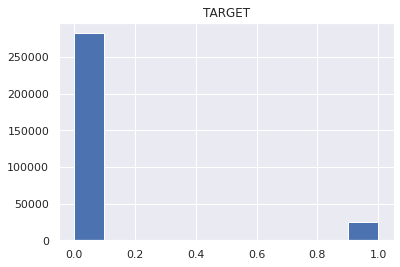

In [11]:
# выборка несбалансированная: хороших клиентов значительно больше
train['TARGET'].hist()
plt.title('TARGET')
plt.show()

#### 1.3.1) Денежные признаки

*   Добавляем новый признак: во сколько раз доход превосходит ежемесячный платеж по кредиту **['INCOME_TO_ANNUITY']**
*   Логарифмируем все 3 денежных признака ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'INCOME_TO_ANNUITY']



In [12]:
# добавляем признак: во сколько раз доход превосходит ежемесячный платеж по кредиту
train['INCOME_TO_ANNUITY'] = train['AMT_INCOME_TOTAL'] / train['AMT_ANNUITY']
test['INCOME_TO_ANNUITY'] = test['AMT_INCOME_TOTAL'] / test['AMT_ANNUITY']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


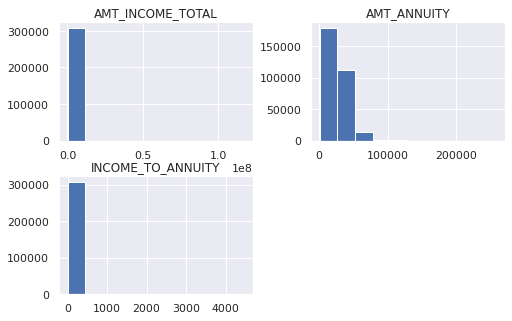

In [13]:
# распределение признаков похоже на логарифмическое
train[['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'INCOME_TO_ANNUITY']].hist(figsize=(8, 5))
plt.show()

In [14]:
# логарифмируем значения, чтобы сделать распределение более близким к нормальному
def logarithmic(df, column):
    df[column] = df[column].apply(lambda x: np.log(x))

for col in ['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'INCOME_TO_ANNUITY']:
    logarithmic(train, col)
    logarithmic(test, col)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


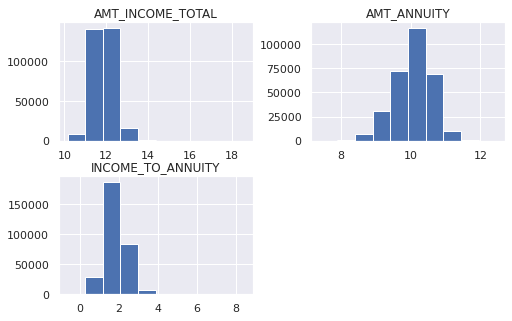

In [15]:
# распределение логарифмированных признаков
train[['AMT_INCOME_TOTAL', 'AMT_ANNUITY', 'INCOME_TO_ANNUITY']].hist(figsize=(8, 5))
plt.show()

#### 1.3.2) Временные признаки

['DAYS_BIRTH', 'DAYS_EMPLOYED']
*   Меняем отрицательные значения на положительные
*   Возраст переводим из дней в годы
*   Срок работы переводим из дней в месяцы

In [16]:
train[['DAYS_BIRTH', 'DAYS_EMPLOYED']].head()

DAYS_BIRTH  DAYS_EMPLOYED
0       -9461           -637
1      -16765          -1188
2      -19046           -225
3      -19005          -3039
4      -19932          -3038

In [17]:
# возраст: переводим дни в годы
train['AGE'] = train['DAYS_BIRTH'].apply(lambda x: - x / 365)
test['AGE'] = test['DAYS_BIRTH'].apply(lambda x: - x / 365)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# срок работы на последней работе: переводим дни в месяцы
train['MONTHS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x: abs(x) / 30.5)
test['MONTHS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x: abs(x) / 30.5)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
train[['AGE', 'MONTHS_EMPLOYED']].head()

AGE  MONTHS_EMPLOYED
0  25.920548        20.885246
1  45.931507        38.950820
2  52.180822         7.377049
3  52.068493        99.639344
4  54.608219        99.606557

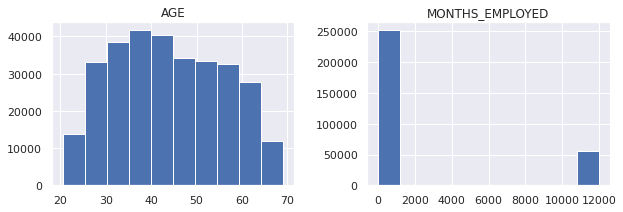

In [20]:
train[['AGE', 'MONTHS_EMPLOYED']].hist(figsize=(10, 3))
plt.show()

#### 1.3.3) Бинарные признаки

['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

*   Заменяем на 0 и 1

In [21]:
train[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].describe()

FLAG_OWN_CAR FLAG_OWN_REALTY
count        307511          307511
unique            2               2
top               N               Y
freq         202924          213312

In [22]:
# Заменяем Y на 1, N - на 0
train['FLAG_OWN_CAR'] = train['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
test['FLAG_OWN_CAR'] = test['FLAG_OWN_CAR'].replace({'Y': 1, 'N': 0})
train['FLAG_OWN_REALTY'] = train['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})
test['FLAG_OWN_REALTY'] = test['FLAG_OWN_REALTY'].replace({'Y': 1, 'N': 0})

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [23]:
train[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']].describe()

FLAG_OWN_CAR  FLAG_OWN_REALTY
count  307511.000000    307511.000000
mean        0.340108         0.693673
std         0.473746         0.460968
min         0.000000         0.000000
25%         0.000000         0.000000
50%         0.000000         1.000000
75%         1.000000         1.000000
max         1.000000         1.000000

#### 1.3.4) Категориальные признаки

Категориальные: семейное положение ['NAME_FAMILY_STATUS']

In [24]:
train.groupby(['NAME_FAMILY_STATUS'])['TARGET'].mean()

NAME_FAMILY_STATUS
Civil marriage          0.099446
Married                 0.075599
Separated               0.081942
Single / not married    0.098077
Unknown                 0.000000
Widow                   0.058242
Name: TARGET, dtype: float64

In [25]:
# кодируем средним значением таргета
family_target_encoding = train.groupby(['NAME_FAMILY_STATUS'])['TARGET'].mean()
train['FAMILY_ENCODED'] = train['NAME_FAMILY_STATUS'].map(family_target_encoding)
test['FAMILY_ENCODED'] = test['NAME_FAMILY_STATUS'].map(family_target_encoding)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### 1.4) Признаки для дальнейшего анализа

In [26]:
features = ['INCOME_TO_ANNUITY',
           'AGE',
           'MONTHS_EMPLOYED',
           'FLAG_OWN_CAR',
           'FLAG_OWN_REALTY',
           'FAMILY_ENCODED',
           'EXT_SOURCE_1',
           'EXT_SOURCE_2',
           'EXT_SOURCE_3']
           
target = ['TARGET']

In [27]:
train = train[target + features]
test = test[features]

### 1.5) Корреляции

*   Корреляция всех переменных с TARGET очень слабая, вряд ли получатся хорошие модели из этих признаков
*   Самая сильная (отрицательная) корреляция с TARGET у скоров из внешних источников
*   Есть автокорреляция между возрастом AGE и сроком работы MONTHS_EMPLOYED -> не будем их включать в модель одновременно

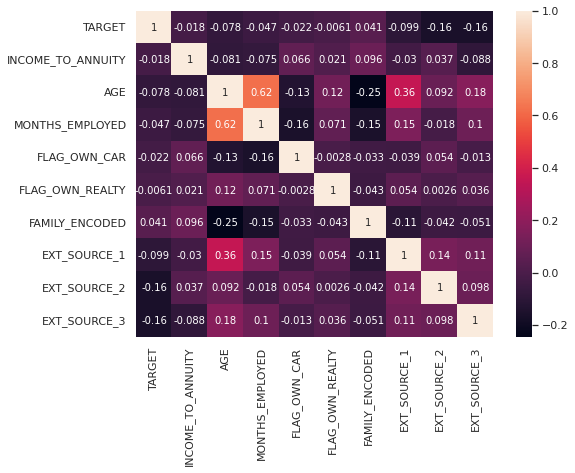

In [28]:
# корреляционная матрица
plt.figure(figsize=(8, 6))
sns.heatmap(train.corr(), annot=True)
plt.show()

## 2) Функция кросс-валидации

На вход: датафрейм, признаки, таргет, количество фолдов

На выход: среднее значение ROC AUC по всем фолдам

In [29]:
def cross_validation(data, features, target, splits = 5):
    roc_auc_list = []

    kf = KFold(n_splits = splits, shuffle = False)
    for i, (train_index, val_index) in enumerate(kf.split(data)):
        train_part = data.loc[train_index, : ]
        val_part = data.loc[val_index, : ]
        model = LogisticRegression(penalty='l2')
        model.fit(X = train_part[features], y = train_part[target[0]])
        val_prediction = model.predict_proba(val_part[features])[:,1]
        metric = roc_auc_score(val_part[target[0]], val_prediction)
        roc_auc_list.append(metric)
        
    return np.mean(roc_auc_list) #, np.std(roc_auc_list), roc_auc_list

In [30]:
def logit_graph(train, target, train_prediction):
    logit_roc_auc = roc_auc_score(train[target], train_prediction)
    fpr, tpr, thresholds = roc_curve(train[target], train_prediction)
    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()

## 3) Модели

### 3.0) Список

In [31]:
# список для значений кросс-валидации по 5 моделям
cv_list = [0] * 5

### 3.1) Модель 1. Только внешние скоры

*   Признаки: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

In [32]:
lst = [['EXT_SOURCE_1'], ['EXT_SOURCE_2'], ['EXT_SOURCE_3'], 
       ['EXT_SOURCE_1', 'EXT_SOURCE_2'], ['EXT_SOURCE_1', 'EXT_SOURCE_3'], ['EXT_SOURCE_2', 'EXT_SOURCE_3'],
       ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']]

for f in lst:
    train1 = train[f + target]
    print(f, round(cross_validation(train1, f, target), 4))

['EXT_SOURCE_1'] 0.5828
['EXT_SOURCE_2'] 0.6559
['EXT_SOURCE_3'] 0.6537
['EXT_SOURCE_1', 'EXT_SOURCE_2'] 0.6758
['EXT_SOURCE_1', 'EXT_SOURCE_3'] 0.6759
['EXT_SOURCE_2', 'EXT_SOURCE_3'] 0.7085
['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'] 0.7194


ROC AUC наибольшая для EXT_SOURCE_3, причем она постепенно возрастает при увеличении количества признаков в модели. Можем использовать в модели все 3 признака, но наиболее хорошо объясняющим является третий.

In [34]:
# модель с тремя факторами
feat = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

model = LogisticRegression(penalty='l2')
model.fit(X = train1[feat], y = train1[target])
train_prediction = model.predict_proba(X = train[feat])[:,1]
test_prediction = model.predict_proba(test[feat])[:,1]
sample_submission['TARGET'] = test_prediction
sample_submission.to_csv('predict1.csv', index = False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [35]:
# скор
score = roc_auc_score(train1[target], train_prediction)
cv_list[0] = score
score

0.7194582969689292

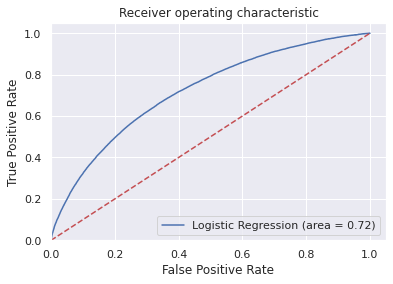

In [36]:
logit_graph(train, target, train_prediction)

In [37]:
# сохраняем предсказание
# files.download("predict1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.2) Модель 2. Один из оставшихся факторов

*   Признаки: ['INCOME_TO_ANNUITY', 'AGE', 'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']

In [38]:
lst = ['INCOME_TO_ANNUITY', 'AGE', 'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']
for f in lst:
    train1 = train[[f] + target]
    print(f, round(cross_validation(train1, [f], target), 4))

INCOME_TO_ANNUITY 0.5195
AGE 0.583
MONTHS_EMPLOYED 0.5915
FLAG_OWN_CAR 0.519
FLAG_OWN_REALTY 0.5052
FAMILY_ENCODED 0.5358


Значения ROC AUC не такие высокие, как в моделях по признакам из внешних источников, однако все выше 0.5 - то есть имеют какую-то объясняющую силу, причем наибольшая ROC AUC - у AGE и MONTHS_EMPLOYED.

In [45]:
train1 = train[lst + target]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5914712329535633


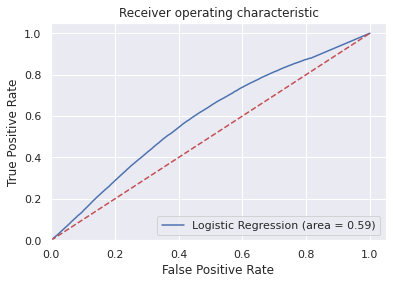

In [48]:
# модель с одним фактором
feat = ['MONTHS_EMPLOYED']

model = LogisticRegression(penalty='l2')
model.fit(X = train1[feat], y = train1[target])
train_prediction = model.predict_proba(X = train[feat])[:,1]
test_prediction = model.predict_proba(test[feat])[:,1]
sample_submission['TARGET'] = test_prediction
sample_submission.to_csv('predict2.csv', index = False)

# скор
score = roc_auc_score(train1[target], train_prediction)
cv_list[1] = score
print(score)

# график
logit_graph(train1, target, train_prediction)

In [49]:
# сохраняем предсказание
files.download("predict2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.3) Модель 3. Внешний скоринг, срок работы и возраст

*   Признаки: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'MONTHS_EMPLOYED', 'AGE']

In [57]:
f = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'MONTHS_EMPLOYED', 'AGE']
train1 = train[f + target]
print(f, round(cross_validation(train1, f, target), 4))

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'MONTHS_EMPLOYED', 'AGE'] 0.7106


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7088935076043188


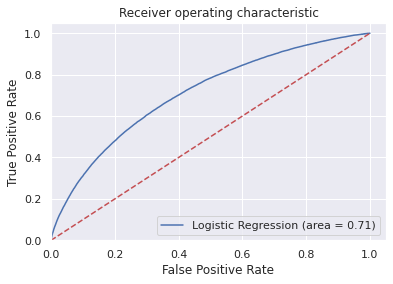

In [58]:
# модель
feat = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'MONTHS_EMPLOYED', 'AGE']

model = LogisticRegression(penalty='l2')
model.fit(X = train1[feat], y = train1[target])
train_prediction = model.predict_proba(X = train1[feat])[:,1]
test_prediction = model.predict_proba(test[feat])[:,1]
sample_submission['TARGET'] = test_prediction
sample_submission.to_csv('predict3.csv', index = False)

# скор
score = roc_auc_score(train1[target], train_prediction)
cv_list[2] = score
print(score)

# график
logit_graph(train1, target, train_prediction)

In [59]:
# сохраняем предсказание
files.download("predict3.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.4) Модель 4. Все признаки, кроме срока занятости и возраста

*   Признаки: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']

In [62]:
f = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']
train1 = train[f + target]
print(f, round(cross_validation(train1, f, target), 4))

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED'] 0.7228


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7229228336353526


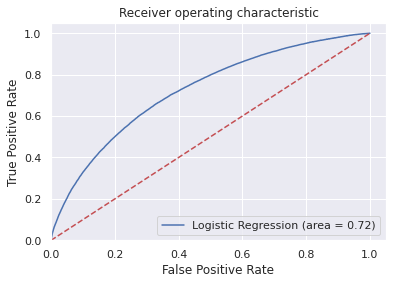

In [63]:
# модель
feat = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']

model = LogisticRegression(penalty='l2')
model.fit(X = train1[feat], y = train1[target])
train_prediction = model.predict_proba(X = train1[feat])[:,1]
test_prediction = model.predict_proba(test[feat])[:,1]
sample_submission['TARGET'] = test_prediction
sample_submission.to_csv('predict4.csv', index = False)

# скор
score = roc_auc_score(train1[target], train_prediction)
cv_list[3] = score
print(score)

# график
logit_graph(train1, target, train_prediction)

In [64]:
# сохраняем предсказание
files.download("predict4.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 3.5) Модель 5. Все признаки, кроме владения недвижимостью

*   Признаки: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'AGE', 'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED']

In [67]:
f = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'AGE', 
     'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FAMILY_ENCODED']
train1 = train[f + target]
print(f, round(cross_validation(train1, f, target), 4))

['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'AGE', 'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FAMILY_ENCODED'] 0.6808


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.708054468770694


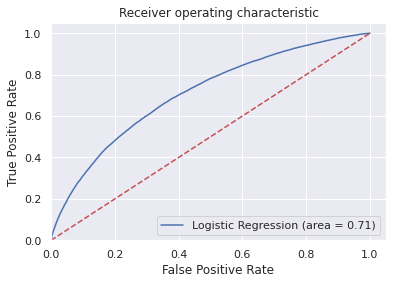

In [69]:
# модель
feat = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'AGE', 
     'MONTHS_EMPLOYED', 'FLAG_OWN_CAR', 'FAMILY_ENCODED']

model = LogisticRegression(penalty='l2')
model.fit(X = train1[feat], y = train1[target])
train_prediction = model.predict_proba(X = train1[feat])[:,1]
test_prediction = model.predict_proba(test[feat])[:,1]
sample_submission['TARGET'] = test_prediction
sample_submission.to_csv('predict5.csv', index = False)

# скор
score = roc_auc_score(train1[target], train_prediction)
cv_list[4] = score
print(score)

# график
logit_graph(train1, target, train_prediction)

In [70]:
# сохраняем предсказание
files.download("predict5.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4) Графики

In [72]:
# скор на Kaggle
kaggle_private = [0.69773, 0.58788, 0.68801, 0.70485, 0.68505]
kaggle_public = [0.70980, 0.60339, 0.69160, 0.71547, 0.68818]

In [73]:
# сравнение скора на кросс-валидации со скором на Kaggle
df_score = pd.DataFrame(list(zip(cv_list, kaggle_private, kaggle_public)), columns = ['cross_validation', 'kaggle_private', 'kaggle_public'])
df_score

cross_validation  kaggle_private  kaggle_public
0          0.719458         0.69773        0.70980
1          0.591471         0.58788        0.60339
2          0.708894         0.68801        0.69160
3          0.722923         0.70485        0.71547
4          0.708054         0.68505        0.68818

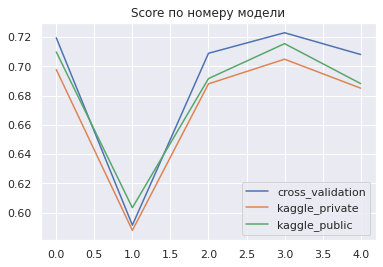

In [74]:
df_score.plot(title = 'Score по номеру модели')
plt.show()

## 5) Выводы

1. Все значения ROC AUC больше 0.5, что хорошо.
2. Скор на кросс-валидации по всем моделям очень близок к скору на Kaggle. Значит, с методикой расчета ROC AUC и кросс-валидацией все в порядке.
3. Наиболее хорошая объясняющая сила - у признаков из внешних источников (ROC AUC от 0.6 до 0.7). Другие признаки не очень хорошо объясняют таргет (ROC AUC от 0.5 до 0.6), их добавление в модель с внешними источниками может как улучшить, так и ухудшить модель.
4. Лучшая модель из полученных - модель 4: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_TO_ANNUITY', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FAMILY_ENCODED'] - с использованием всех внешних источников и признаков соотношения дохода и выплат по кредиту, владения машиной и недвижимостью, семейным положением.
